In [51]:
import os
import utils
import dotenv
import umap
import pandas as pd
import numpy as np
import dataextraction as db
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, SpectralClustering, KMeans, Birch
import hdbscan

In [52]:
# Loads the environment variables from the .env file
dotenv.load_dotenv()

True

In [53]:
df = pd.read_csv(f'{os.getenv("ROOT_DIR")}\\data\\finalrefined.csv')

In [54]:
df

,subject_id,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,aniongap_mean,...,discharge_location_OTHER FACILITY,discharge_location_REHAB/DISTINCT PART HOSP,discharge_location_SHORT TERM HOSPITAL,discharge_location_SNF,discharge_location_SNF-MEDICAID ONLY CERTIF,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,insurance_Self Pay
0,3,111.785714,102.960000,55.720000,75.692812,17.361111,37.002881,97.870968,232.416667,19.000000,...,False,False,False,True,False,False,False,True,False,False
1,9,92.500000,159.375000,79.525000,98.850000,14.369565,37.049383,97.650000,161.285714,13.000000,...,False,False,False,False,False,False,True,False,False,False
2,21,71.385714,101.817016,44.110723,65.891024,16.838690,36.796465,98.057598,160.000000,21.000000,...,False,False,False,False,False,False,False,True,False,False
3,25,72.906250,100.000000,46.583333,63.324330,16.031250,36.333333,97.096774,164.766667,13.000000,...,False,False,False,False,False,False,False,False,True,False
4,31,51.230769,114.153846,59.923077,79.923077,12.066667,36.958333,98.714286,108.142857,9.500000,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10188,99913,93.676471,117.111111,51.166667,69.194444,18.200000,36.936000,98.562500,129.434783,11.500000,...,False,False,False,False,False,False,False,True,False,False
10189,99922,86.185185,111.068966,55.206897,69.206897,15.678571,36.555128,97.592593,124.684211,11.000000,...,False,False,False,False,False,False,False,True,False,False
10190,99923,95.006944,106.881558,59.216216,72.278219,15.500000,36.516204,97.685484,130.333333,15.000000,...,False,False,False,False,False,False,False,False,True,False
10191,99944,74.461538,130.730769,53.923077,72.769231,22.600000,36.111111,94.423077,138.000000,17.000000,...,False,False,False,True,False,False,False,True,False,False


In [55]:
df_subject_mr = utils.aggregate_score_to_mortality()
df_subject_mr

Connected to the PostgreSQL database
PostgreSQL version: PostgreSQL 14.0, compiled by Visual C++ build 1914, 64-bit


,subject_id,mr_lods
0,25225,0.104107
1,15574,0.048017
2,52619,0.048017
3,85940,0.048017
4,12411,0.288948
...,...,...
61046,3793,0.149936
61047,11099,0.288948
61048,93831,0.071114
61049,50334,0.104107


In [56]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [57]:
pca = PCA(n_components=20)
pca_result = pca.fit_transform(scaled_data)

In [58]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(pca_result)

In [59]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_reducer.fit_transform(pca_result)

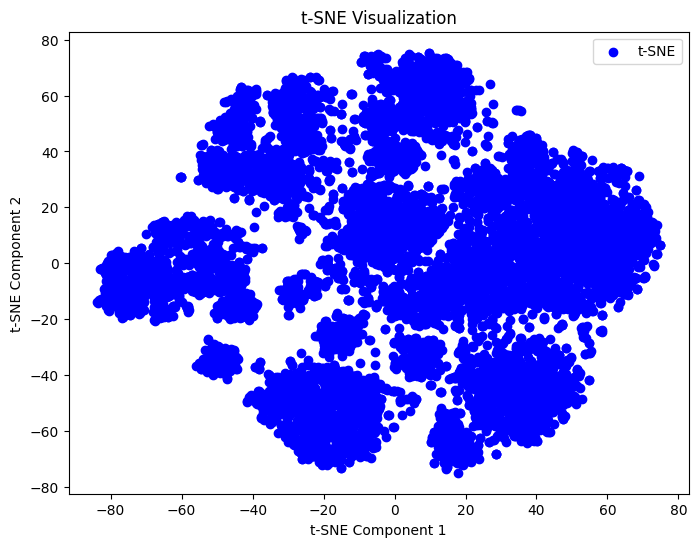

In [60]:
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='b', marker='o', label='t-SNE')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

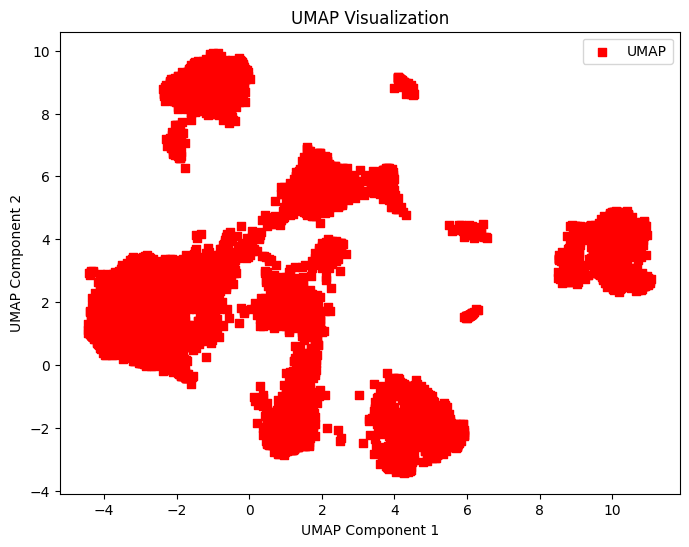

In [61]:
plt.figure(figsize=(8, 6))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c='r', marker='s', label='UMAP')
plt.title('UMAP Visualization')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

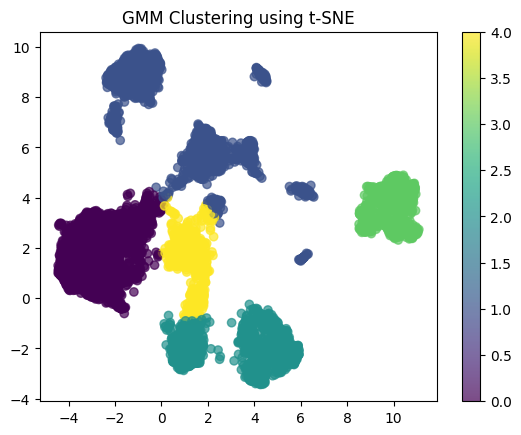

In [62]:
n_clusters = 5

gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(umap_result)

df['GMM_Cluster_UMAP'] = gmm_labels

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=gmm_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('GMM Clustering using t-SNE')
plt.show()

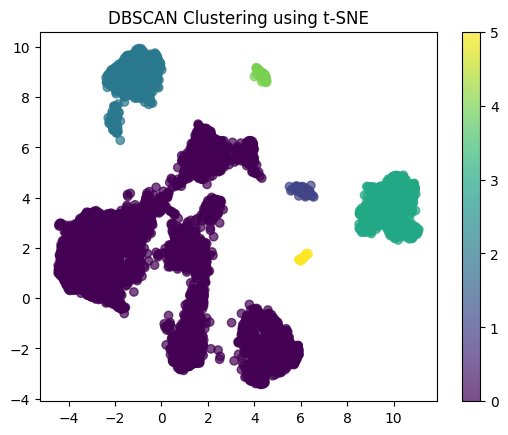

In [63]:
eps = 0.8
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(umap_result)

df['DBSCAN_Cluster'] = dbscan_labels

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('DBSCAN Clustering using t-SNE')
plt.show()

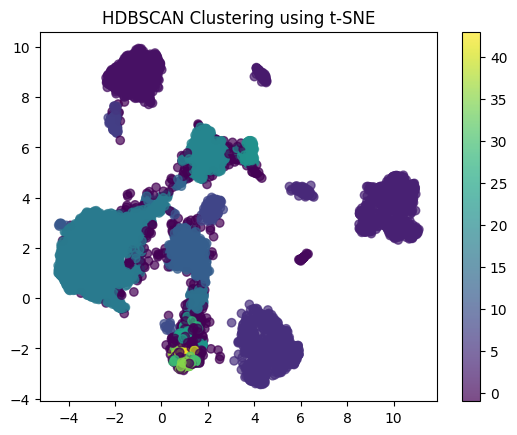

In [64]:
min_cluster_size = 5

hdb = hdbscan.HDBSCAN(min_samples=min_cluster_size)
hdb_labels = hdb.fit_predict(umap_result)

df['HDBSCAN_Cluster'] = hdb_labels

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=hdb_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('HDBSCAN Clustering using t-SNE')
plt.show()

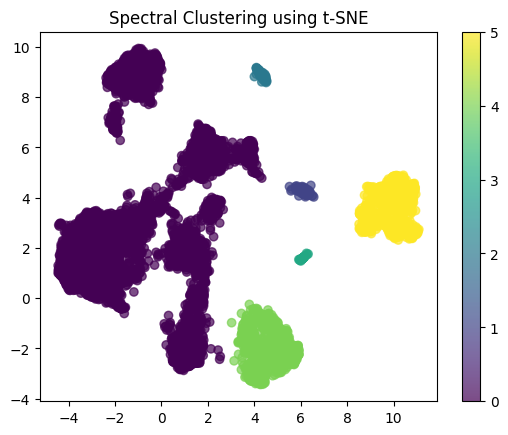

In [65]:
n_clusters = 6

spectral_clustering = SpectralClustering(n_clusters=n_clusters, eigen_solver='arpack', random_state=42)
spectral_labels = spectral_clustering.fit_predict(umap_result)

df['Spectral_Cluster'] = spectral_labels

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=spectral_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('Spectral Clustering using t-SNE')
plt.show()

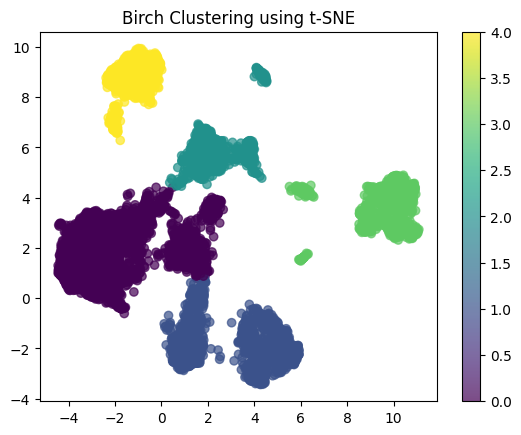

In [66]:
n_clusters = 5

birch = Birch(n_clusters=n_clusters)
birch_labels = birch.fit_predict(umap_result)

df['Birch_Cluster'] = birch_labels

# Plotting the Birch clusters in 2D (assuming tsne_result, you can use umap_result as well)
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=birch_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('Birch Clustering using t-SNE')
plt.show()

d:\workspace\github\icu-flow-prediction\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


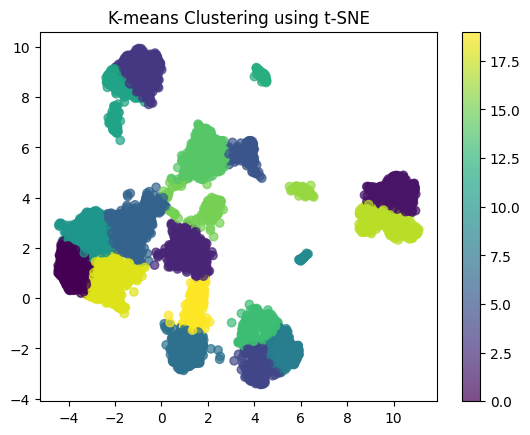

In [67]:
n_clusters = 20

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(umap_result)

df['KMeans_Cluster'] = kmeans_labels

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('K-means Clustering using t-SNE')
plt.show()

In [68]:
df = df.merge(df_subject_mr.drop_duplicates(subset='subject_id'), on='subject_id', how='left')

In [69]:
average_mortality = df.groupby('KMeans_Cluster')['mr_lods'].mean()

print("Average Mortality Rate for Each Cluster:")
print(average_mortality)

Average Mortality Rate for Each Cluster:
KMeans_Cluster
0     0.190438
1     0.247556
2     0.453000
3     0.131732
4     0.168884
5     0.174388
6     0.303014
7     0.203396
8     0.257847
9     0.164576
10    0.157520
11    0.242402
12    0.184831
13    0.227835
14    0.192380
15    0.352749
16    0.175130
17    0.170822
18    0.267498
19    0.402446
Name: mr_lods, dtype: float64


In [70]:
median_mortality = df.groupby('Birch_Cluster')['mr_lods'].median()

print("Median Mortality Rate for Each Cluster:")
print(median_mortality)

Median Mortality Rate for Each Cluster:
Birch_Cluster
0    0.211185
1    0.149936
2    0.149936
3    0.149936
4    0.104107
Name: mr_lods, dtype: float64


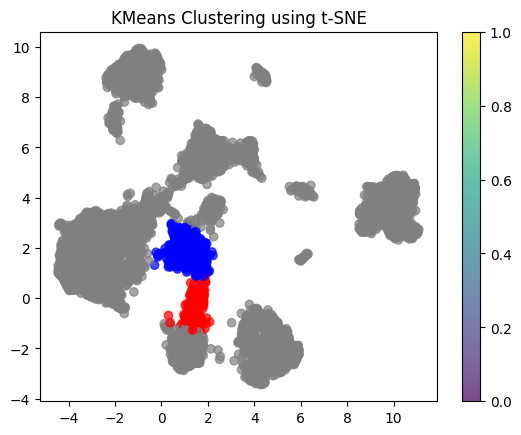

In [72]:
num_clusters = len(average_mortality)
colors = ['grey'] * num_clusters

colors[2] = 'blue'
colors[19] = 'red'

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=[colors[label] for label in df["KMeans_Cluster"]], alpha=0.7)

plt.colorbar()
plt.title('KMeans Clustering using t-SNE')
plt.show()